# 전이학습 주식데이터 예측

- m4 data 24주기의 소스데이터
- targetdata는 시간별 종가 주식데이터이고 5주기이다.
- 앞으로의 12시차를 예측하고 싶음
- 학습할 때는 하루 차이를 두어 model fitting 진행
- seq2seq 형식으로 변경

In [130]:
#import pandas_datareader.data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasetsforecast.m4 import M4, M4Evaluation
import time
from keras.layers import *
from keras.models import Sequential ,Model
from keras.callbacks import EarlyStopping
import keras.backend as K

# source m4 data 

In [131]:
df,*_= M4.load(directory='data',group = 'Hourly')

lst = list(set(df.loc[:,'unique_id']))

tt = [df[df.loc[:,'unique_id']==lst[i]].iloc[:,1:4].set_index(['ds']) 
      for i in range(len(lst))]

for l in range(len(tt)):
    for s in range(1, 25):
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        
tt=[tt[i].dropna(axis=0) for i in range(len(tt))]

train = np.concatenate([np.array(tt[i].iloc[:,1:]) for i in range(len(tt))])
y = np.concatenate([np.array(tt[i].iloc[:,0]) for i in range(len(tt))]).reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler1 = MinMaxScaler()

X_scale = min_max_scaler1.fit_transform(train)
y_scale = min_max_scaler1.fit_transform(y)

# target data

In [143]:
start_date = '2023-01-01'
end_date ='2024-01-01'

ticker = yf.Ticker('005930.KS')
 
df1= ticker.history(
               interval='1h',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=True)
df1= df1[['Close']].values.flatten().reshape(-1, 1)

In [147]:
scale_target= min_max_scaler1.fit_transform(df1)
target= pd.DataFrame({'y':scale_target.flatten()})

In [123]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

In [227]:
cake = WINdow(target,24)

In [228]:
cake.window()
X_train= cake.feature
#X_train[:-24].shape,X_train[24:].shape

((1420, 24), (1420, 24))

In [229]:
start_date = '2024-01-02'
end_date ='2024-02-02'

ticker = yf.Ticker('005930.KS')
 
df2= ticker.history(
               interval='1h',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=True)
df2= df2[['Close']].values.flatten().reshape(-1, 1)

scale_target2= min_max_scaler1.fit_transform(df2)
target2= pd.DataFrame({'y':scale_target2.flatten()})

cake2 = WINdow(target2,24)

In [230]:
cake2.window()
X_test= cake2.feature
#X_test[:-24].shape,X_test[24:].shape

((89, 24), (89, 24))

---

# pretrained model fitting

In [155]:
K.clear_session()
model01 = Sequential() # Sequeatial Model
model01.add(LSTM(64, return_sequences=True, input_shape=(24, 1))) # (timestep, feature)
model01.add(LSTM(64, return_sequences=True)) # 연결한 모델의 차원을 맞추기 위해 시퀀스 반환을 함
model01.add(Dense(1)) # output 사용 x
model01.compile(loss='mean_squared_error', optimizer='adam')
np.random.seed(1)
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model01.fit(X_scale, y_scale, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100


2840/2840 [==============================] - 45s 15ms/step - loss: 1.5430e-04
Epoch 2/100
2840/2840 [==============================] - 42s 15ms/step - loss: 1.8609e-05
Epoch 3/100
2840/2840 [==============================] - 43s 15ms/step - loss: 9.4355e-06
Epoch 4/100
2840/2840 [==============================] - 45s 16ms/step - loss: 7.5013e-06
Epoch 5/100
2840/2840 [==============================] - 46s 16ms/step - loss: 5.9220e-06
Epoch 6/100
2840/2840 [==============================] - 47s 17ms/step - loss: 4.8200e-06
Epoch 7/100
2840/2840 [==============================] - 47s 17ms/step - loss: 4.2194e-06
Epoch 8/100
2840/2840 [==============================] - 45s 16ms/step - loss: 4.1059e-06
Epoch 9/100
2840/2840 [==============================] - 44s 15ms/step - loss: 3.2705e-06
Epoch 10/100
2840/2840 [==============================] - 45s 16ms/step - loss: 3.0131e-06
Epoch 11/100
2840/2840 [==============================] - 45s 16ms/step - loss: 2.8367e-06
Epoch 12/100
2840/28

In [315]:
pretrained_layers = model01.layers[:-1]
for layer in model01.layers:
    layer.trainable = True # freezing
    
K.clear_session()
model012 = Sequential(pretrained_layers)
model012.add(LSTM(64, name='lstmd2',input_shape=(24,64), return_sequences=True))
model012.add(TimeDistributed(Dense(1)))
model012.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0)
start_time22 = time.time()
model012.fit(X_train[:-24], X_train[24:], epochs=10,
          batch_size=1, verbose=1, callbacks=[early_stop])
end_time22 = time.time()

Epoch 1/10
1420/1420 [==============================] - 15s 8ms/step - loss: 0.0073
Epoch 2/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0044
Epoch 3/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0045
Epoch 4/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0044
Epoch 5/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0043
Epoch 6/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0043
Epoch 7/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0042
Epoch 8/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0042
Epoch 9/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0042
Epoch 10/10
1420/1420 [==============================] - 12s 8ms/step - loss: 0.0041


---

# no-pretrained model

In [316]:
K.clear_session()
modelnon0 = Sequential() # Sequeatial Model
modelnon0.add(LSTM(64, return_sequences=True,input_shape=(24, 1)))# (timestep, feature)
modelnon0.add(LSTM(64, return_sequences=True))
modelnon0.add(TimeDistributed(Dense(1))) # output = 1
modelnon0.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
start_timenon0 = time.time()
modelnon0.fit(X_train[:-24],X_train[24:], epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])
end_timenon0 = time.time()

Epoch 1/100
1420/1420 [==============================] - 10s 5ms/step - loss: 0.0088
Epoch 2/100
1420/1420 [==============================] - 8s 5ms/step - loss: 0.0048
Epoch 3/100
1420/1420 [==============================] - 8s 5ms/step - loss: 0.0048
Epoch 3: early stopping


---

# test

In [319]:
pred1 = model012.predict(X_test[:-24])
pred2 = modelnon0.predict(X_test[:-24])

3/3 [==============================] - 1s 3ms/step


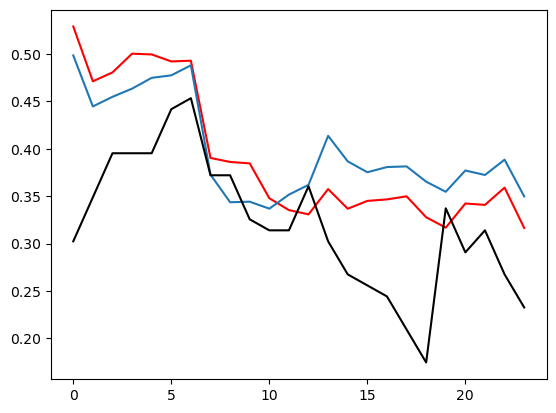

In [320]:
plt.plot(pred1[-1],color='red')
plt.plot(pred2[-1])
plt.plot(X_test[-1],color='black')

In [321]:
from sklearn.metrics import mean_squared_error as mse
mse1,mse2 = mse(X_test[-1],pred1[-1]),mse(X_test[-1],pred2[-1])
print('pretrain',mse1,'\nnormal',mse2)


pretrain 0.008131648222782943 
normal 0.009715282244397572
